# PostAnalysis for sequencing of Merfish oligo pool

by Pu Zheng

2023.11.21

In [23]:
# Basic imports
import os,sys,re
from importlib import reload
import numpy as np
import pandas as pd
#import torch
print(os.getpid())

877038


In [24]:
# ChromAn related imports
sys.path.append(r'/lab/weissman_imaging/puzheng/Softwares/') # parent folder of ChromAn
import ImageAnalysis3 as ia3
import h5py
from ImageAnalysis3.classes import _allowed_kwds
import ast
from ChromAn.src import file_io

from ChromAn.src.file_io import dax_process
from ChromAn.src.file_io import data_organization
from ChromAn.src.visual_tools import interactive
from ChromAn.src.correction_tools.alignment import generate_drift_crops
from ChromAn.src.spot_tools.match_spots import colocalize_spots

import pickle

import matplotlib.pyplot as plt

In [6]:
data_folder = r'/lab/solexa_weissman/puzheng/Sequencing_data/231120_M01799_0478_000000000-KGY2N/'
analysis_folder = os.path.join(data_folder, 'Analysis')

# load probes

In [7]:
# Load probes:
from Bio import SeqIO

probe_filename = os.path.join(analysis_folder, 'All_probes.fasta')
print(probe_filename)

probes = []
for record in SeqIO.parse(probe_filename, "fasta"):
    probes.append(record)
print(len(probes))

/lab/solexa_weissman/puzheng/Sequencing_data/231120_M01799_0478_000000000-KGY2N/Analysis/All_probes.fasta
222042


In [8]:
probe_df = pd.DataFrame({
    'name':[ _pb.name for _pb in probes],
    'sequence': [str(_pb.seq) for _pb in probes],
})
probe_df

,name,sequence
0,MF1_Igkc_ENSMUST00000103410.3_shift-0_GC-53.3_...,CCCGCAATGGCTGACAACCGGTCCTGTTCTTGTCGAGCGTGTCCTG...
1,MF1_Iglc2_ENSMUST00000103749.3_shift-0_GC-50.0...,CCCGCAATGGCTGACAACCGGTCCTGTTCTTGTCGAGCGTGTCCTG...
2,MF1_Il21_ENSMUST00000029273.8_shift-0_GC-56.6_...,CCCGCAATGGCTGACAACCGGTCCTGTTCTTGTCGAGCGTGTCCTG...
3,MF1_Xcl1_ENSMUST00000027860.8_shift-0_GC-53.3_...,CCCGCAATGGCTGACAACCGGTCCTGTTCTTGTCGAGCGTGTCCTG...
4,MF1_S100a10_ENSMUST00000148400.2_shift-0_GC-56...,CCCGCAATGGCTGACAACCGGTCCTGTTCTTGTCGAGCGTGTCCTG...
...,...,...
222037,MO4_sequential_4326a528-01_Igfbp6__ENSMUST0000...,TAAGGTAGCTGTCGCCGCAGATGCTCCTGGCAGAGCACTGAGTGCT...
222038,MO4_sequential_4326a528-01_Igfbp6__ENSMUST0000...,TAAGGTAGCTGTCGCCGCAGAGAACGACACTGCTGCTTTCGGTAGA...
222039,MO4_sequential_4326a528-01_Igfbp6__ENSMUST0000...,TAAGGTAGCTGTCGCCGCAGACATTGCTTCACATACAGCTCAAATG...
222040,MO4_sequential_4326a528-01_Igfbp6__ENSMUST0000...,TAAGGTAGCTGTCGCCGCAGAAGACAGCCTCCGGCTTCTGTACAGC...


In [9]:
# load analysis 
sequence_folder = os.path.join(data_folder, '20231121_081440', 'Fastq')
alignment_stats = [os.path.join(sequence_folder, _f) for _f in os.listdir(sequence_folder) if '.idxstats' in _f]
alignment_stats

['/lab/solexa_weissman/puzheng/Sequencing_data/231120_M01799_0478_000000000-KGY2N/20231121_081440/Fastq/Amplified-MF2_S6_L001.idxstats',
 '/lab/solexa_weissman/puzheng/Sequencing_data/231120_M01799_0478_000000000-KGY2N/20231121_081440/Fastq/Amplified-MO4_S4_L001.idxstats',
 '/lab/solexa_weissman/puzheng/Sequencing_data/231120_M01799_0478_000000000-KGY2N/20231121_081440/Fastq/Amplified-IntBC-30no_S5_L001.idxstats',
 '/lab/solexa_weissman/puzheng/Sequencing_data/231120_M01799_0478_000000000-KGY2N/20231121_081440/Fastq/Amplified-MF3_S2_L001.idxstats',
 '/lab/solexa_weissman/puzheng/Sequencing_data/231120_M01799_0478_000000000-KGY2N/20231121_081440/Fastq/PCR-MF3_S1_L001.idxstats',
 '/lab/solexa_weissman/puzheng/Sequencing_data/231120_M01799_0478_000000000-KGY2N/20231121_081440/Fastq/Twist-MO4_S3_L001.idxstats']

## MF3

In [10]:
library_name = 'MF3'

lib_probe_df = probe_df.loc[
    np.array([library_name in _n for _n in probe_df['name']])
]

amplified_pool_stat = pd.read_table([_f for _f in alignment_stats if library_name in _f and 'amplified' in _f.lower()][0],
                                    header=None, names=['ref', 'length', 'mapped', 'unmapped'])
lib_amplified_match_df = amplified_pool_stat.loc[
    np.array([library_name in _n for _n in probe_df['name']]+[False])
]
lib_amplified_match_df = pd.concat([lib_amplified_match_df, lib_probe_df], axis=1)
len(lib_amplified_match_df), amplified_pool_stat['mapped'].sum(), amplified_pool_stat['unmapped'].sum()

(33952, 1687382, 255574)

In [11]:
np.mean(lib_amplified_match_df['mapped']), np.sum(lib_amplified_match_df['mapped']==0) / len(lib_amplified_match_df)

(49.5631479736098, 0.0004123468426013195)

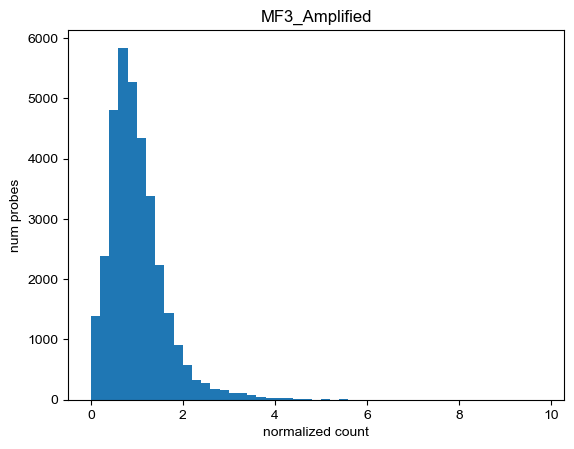

In [12]:
plt.figure()
plt.hist(lib_amplified_match_df['mapped'].values / np.mean(lib_amplified_match_df['mapped']), 
         bins=np.arange(0,10, 0.2))
plt.xlabel('normalized count')
plt.ylabel('num probes')
plt.title(f"{library_name}_Amplified")
plt.show()

In [13]:
lib_amplified_match_df

,ref,length,mapped,unmapped,name,sequence
93437,MF3-msBrain-immune_Idh3g_ENSMUST00000156299.8_...,150,75,0,MF3-msBrain-immune_Idh3g_ENSMUST00000156299.8_...,CCCGCAATGGCTGACAACCGGTCCTGTTCTTGTCGAGCGTGTCCTG...
93438,MF3-msBrain-immune_Fcrla_ENSMUST00000046322.14...,150,40,0,MF3-msBrain-immune_Fcrla_ENSMUST00000046322.14...,CCCGCAATGGCTGACAACCGGTCCTGTTCTTGTCGAGCGTGTCCTG...
93439,MF3-msBrain-immune_Gimap1_ENSMUST00000203797.2...,150,53,0,MF3-msBrain-immune_Gimap1_ENSMUST00000203797.2...,CCCGCAATGGCTGACAACCGGTCCTGTTCTTGTCGAGCGTGTCCTG...
93440,MF3-msBrain-immune_Csmd3_ENSMUST00000162830.8_...,150,28,0,MF3-msBrain-immune_Csmd3_ENSMUST00000162830.8_...,CCCGCAATGGCTGACAACCGGTCCTGTTCTTGTCGAGCGTGTCCTG...
93441,MF3-msBrain-immune_Gna15_ENSMUST00000043709.8_...,150,65,0,MF3-msBrain-immune_Gna15_ENSMUST00000043709.8_...,CCCGCAATGGCTGACAACCGGTCCTGTTCTTGTCGAGCGTGTCCTG...
...,...,...,...,...,...,...
127384,MF3-msBrain-immune_Slc4a8_ENSMUST00000023776.1...,150,37,0,MF3-msBrain-immune_Slc4a8_ENSMUST00000023776.1...,CCCGCAATGGCTGACAACCGCCCATGATCGTCCGATCTGGCCCATG...
127385,MF3-msBrain-immune_Mgam_ENSMUST00000238599.2_s...,150,15,0,MF3-msBrain-immune_Mgam_ENSMUST00000238599.2_s...,CCCGCAATGGCTGACAACCGCCCATGATCGTCCGATCTGGCCCATG...
127386,MF3-msBrain-immune_Slc4a8_ENSMUST00000023776.1...,150,49,0,MF3-msBrain-immune_Slc4a8_ENSMUST00000023776.1...,CCCGCAATGGCTGACAACCGCCCATGATCGTCCGATCTGGCCCATG...
127387,MF3-msBrain-immune_Zfp318_ENSMUST00000113481.9...,150,33,0,MF3-msBrain-immune_Zfp318_ENSMUST00000113481.9...,CCCGCAATGGCTGACAACCGCCCATGATCGTCCGATCTGGCCCATG...


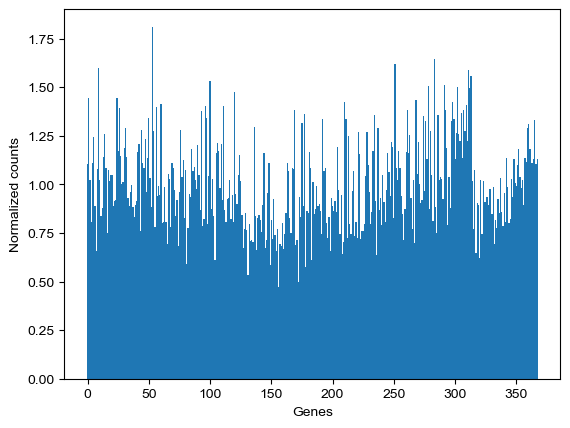

In [14]:
# split by gene
gene_2_amplified_match_df = {}
for _i, _row in lib_amplified_match_df.iterrows():
      _gene = _row['name'].split('_')[1]
      #print(_gene)
      if _gene not in gene_2_amplified_match_df:
            gene_2_amplified_match_df[_gene] = [_row['mapped']]
      else:
            gene_2_amplified_match_df[_gene].append(_row['mapped'])
plt.figure()
gene_total_counts = [np.sum(_v)/np.mean(lib_amplified_match_df['mapped'])/len(_v) for _v in gene_2_amplified_match_df.values()]
plt.bar(np.arange(len(gene_total_counts)), gene_total_counts, width=1)
plt.xlabel('Genes')
plt.ylabel('Normalized counts')
#for _gene, _counts in gene_2_amplified_matches.items():
#    plt.hist(_counts, bins=np.arange(0,100, 5), label=f"{_gene}")
plt.show()
      

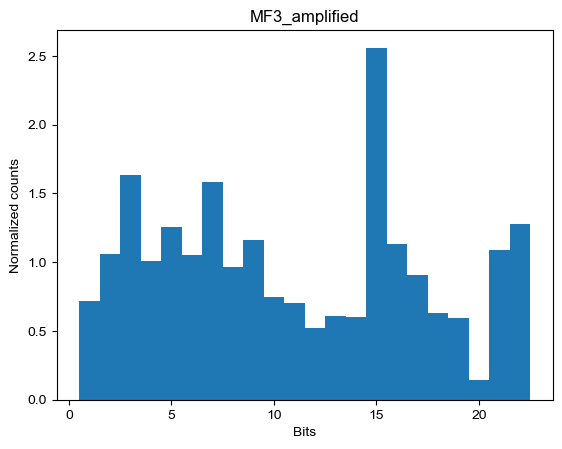

In [15]:
# split by probe
probe_2_amplified_matches = {}
for _i, _row in lib_amplified_match_df.iterrows():
      _probe = _row['name'].split('-')[-1]
      if _probe not in probe_2_amplified_matches:
            probe_2_amplified_matches[_probe] = [_row['mapped']]
      else:
            probe_2_amplified_matches[_probe].append(_row['mapped'])
probes = [_k for _k in sorted(probe_2_amplified_matches.keys(), key=lambda v:int(v.split('_')[1]))]
probe_total_counts = [np.sum(probe_2_amplified_matches[_p])/np.mean(lib_amplified_match_df['mapped'])/len(probe_2_amplified_matches[_p]) 
                      for _p in probes]

plt.figure()
plt.bar(np.arange(len(probe_total_counts))+1, probe_total_counts, width=1)
plt.xlabel('Bits')
plt.ylabel('Normalized counts')
plt.title(f"{library_name}_amplified")
#for _gene, _counts in gene_2_amplified_matches.items():
#    plt.hist(_counts, bins=np.arange(0,100, 5), label=f"{_gene}")
plt.show()

## MF3 PCR


In [16]:

lib_probe_df = probe_df.loc[
    np.array([library_name in _n for _n in probe_df['name']])
]

pcr_pool_stat = pd.read_table([_f for _f in alignment_stats if library_name in _f and 'pcr' in _f.lower()][0],
                                    header=None, names=['ref', 'length', 'mapped', 'unmapped'])
lib_pcr_match_df = pcr_pool_stat.loc[
    np.array([library_name in _n for _n in probe_df['name']]+[False])
]
lib_pcr_match_df = pd.concat([lib_pcr_match_df, lib_probe_df], axis=1)
len(lib_pcr_match_df), pcr_pool_stat['mapped'].sum(), pcr_pool_stat['unmapped'].sum()

(33952, 1566560, 237283)

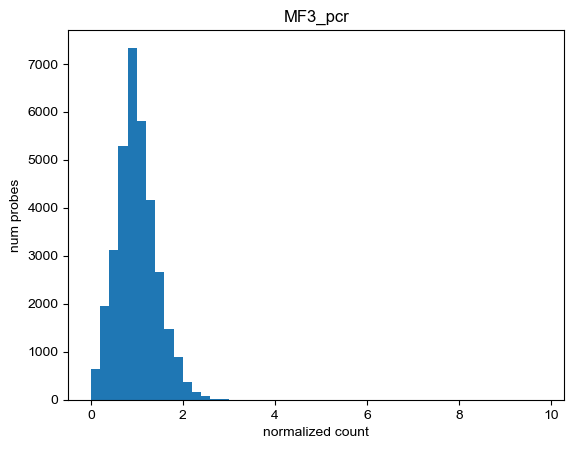

In [18]:
plt.figure()
plt.hist(lib_pcr_match_df['mapped'].values / np.mean(lib_pcr_match_df['mapped']), 
         bins=np.arange(0,10, 0.2))
plt.xlabel('normalized count')
plt.ylabel('num probes')
plt.title(f"{library_name}_pcr")
plt.show()

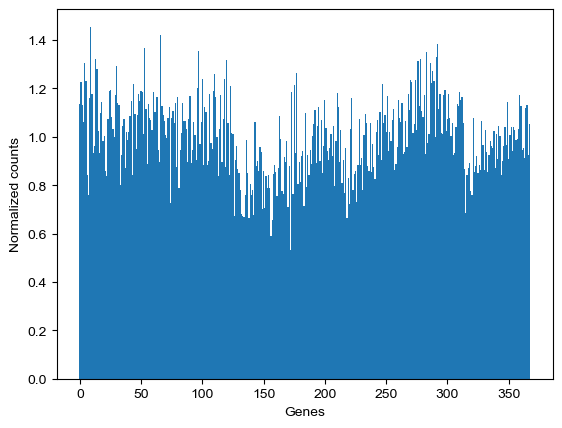

In [20]:
# split by gene
gene_2_pcr_match_df = {}
for _i, _row in lib_pcr_match_df.iterrows():
    _gene = _row['name'].split('_')[1]
    #print(_gene)
    if _gene not in gene_2_pcr_match_df:
        gene_2_pcr_match_df[_gene] = [_row['mapped']]
    else:
        gene_2_pcr_match_df[_gene].append(_row['mapped'])
plt.figure()
gene_total_counts = [np.sum(_v)/np.mean(lib_pcr_match_df['mapped'])/len(_v) for _v in gene_2_pcr_match_df.values()]
plt.bar(np.arange(len(gene_total_counts)), gene_total_counts, width=1)
plt.xlabel('Genes')
plt.ylabel('Normalized counts')
#for _gene, _counts in gene_2_pcr_matches.items():
#    plt.hist(_counts, bins=np.arange(0,100, 5), label=f"{_gene}")
plt.show()
      

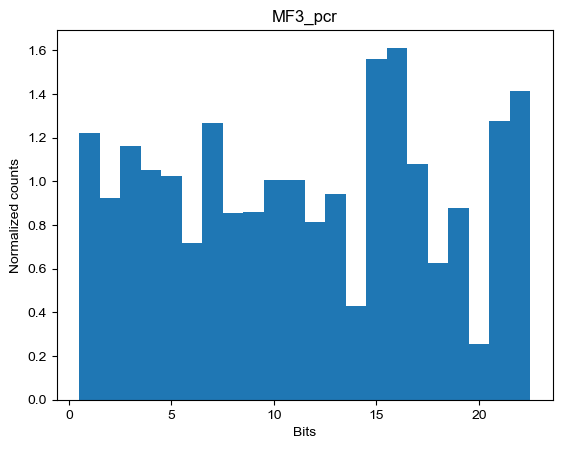

In [22]:
# split by probe
probe_2_pcr_matches = {}
for _i, _row in lib_pcr_match_df.iterrows():
    _probe = _row['name'].split('-')[-1]
    if _probe not in probe_2_pcr_matches:
        probe_2_pcr_matches[_probe] = [_row['mapped']]
    else:
        probe_2_pcr_matches[_probe].append(_row['mapped'])
probes = [_k for _k in sorted(probe_2_pcr_matches.keys(), key=lambda v:int(v.split('_')[1]))]
probe_total_counts = [np.sum(probe_2_pcr_matches[_p])/np.mean(lib_pcr_match_df['mapped'])/len(probe_2_pcr_matches[_p]) 
                      for _p in probes]

plt.figure()
plt.bar(np.arange(len(probe_total_counts))+1, probe_total_counts, width=1)
plt.xlabel('Bits')
plt.ylabel('Normalized counts')
plt.title(f"{library_name}_pcr")
#for _gene, _counts in gene_2_pcr_matches.items():
#    plt.hist(_counts, bins=np.arange(0,100, 5), label=f"{_gene}")
plt.show()